# 电影评论文本分类
[toc]

## 导入库

**re library** 引入新的字符串表达方式 

**shutil** --- 高级文件操作 提供一些支持文件拷贝和删除的函数

**os** --- 多种操纵系统接口

**string** --- 常见字符串操作


In [19]:
import matplotlib.pyplot as plt
import os 
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
os.getcwd()

'd:\\Desktop files\\Python_projects\\TensFlow_tutorial_personal'

## 下载IMDB数据集 
浏览目录结构

 这篇训练的目的是对电影评论进行正向或者负向分类 二元分类
 

 tf.keras.utils.get_file() 

 Downloads a file from a URL if it not already in the cache.
 
 tf.keras.utils.get_file(
    fname=None,
    origin=None,
    untar=False,
    md5_hash=None,
    file_hash=None,
    cache_subdir='datasets',
    hash_algorithm='auto',
    extract=False,
    archive_format='auto',
    cache_dir=None,
    force_download=False
)


 os.path.join()  连接文件,并用'\'分隔开各个文件

In [26]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
dataset_dir = os.path.join('.\\aclImdb_v1', 'aclImdb')
os.listdir(dataset_dir)

文件夹格式.//aclImdb_v1//aclImdb或者 .\\aclImdb_v1\\aclImdb 都可以，官网给的教程找不到文件夹，自己找到文件夹改就行

In [45]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(trian_dir)
# print(trian_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

aclImdb/train/pos和aclImdb/train.neg目录包含许多文本文件，每个文件都是一条电影评论

In [46]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## 加载数据集
加载数据并将其准备为适合训练的格式，使用tf.keras.preprocessing.text_dataset_from_directory 构建数据目录为以下格式

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt

```

移除其他的文件夹

shutil. rmtree() allows you to delete a directory and all of its files and subdirectories. 

In [ ]:
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)


In [ ]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

将数据集分成三份：训练，测试和验证

已有测试集情况下，将训练集拆分为训练集和验证集

使用text_dataset_from_directory 工具进行拆分

In [53]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [55]:
for text_batch,label_batch in raw_train_ds.take(1):
    for i in range(5):
        print("Review", text_batch[i])
        print(" ", label_batch[i])

Review tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
  tf.Tensor(0, shape=(), dtype=int32)
Review tf.Tensor(b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series o

评论包含原始文本，标点符号和html代码，之后会进行处理

标签为 0或1需要对应 正向或反向评论

In [57]:
print("Label 0:", raw_train_ds.class_names[0])
print("Lable 1 :", raw_train_ds.class_names[1])

Label 0: neg
Lable 1 : pos


使用seed 保证拆分后的验证和训练集不重叠

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size = batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed   
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [59]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


## 对训练数据进行预处理

使用tf.keras.layers.TextVectorization 层对数据进行标准化,词例化和向量化。

标准化： 对文本预处理，移除标点符号和html元素，简化数据集

词例化：将字符串分割为词例

向量化：将词例转化为数字，方便神经网络处理

评论中的html 如<b> TextVectorization 并不能处理，需要自定义标准化函数移除文本中的html

In [95]:
def cosutom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase,'<b />',' ')
    cleaned_text = tf.strings.regex_replace(stripped_html,
                            '[%s]'%re.escape(string.punctuation),
                            '')
    return cleaned_text

创建 TextVectorization层，对数据进行标准化，设置output_mode为int方便为每个词例创建整数索引

定义一些常量，最大句子长度等

In [96]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=cosutom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

使用adapt处理数据集，构建字符串到整数的索引

In [97]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [99]:
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1)
    return vectorize_layer(text),label
    

In [100]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("review",first_review)
print("label", first_label)
print("vectorized review:",vectorize_text(first_review,first_label))

review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

每一个词例都被一个整数替换了，通过使用vectorize.layer.get_vocabulary() 来查找每个整数对应的词例

In [101]:
print("111--->",vectorize_layer.get_vocabulary()[111])

111---> little


将之前创建的TextVectorization 层用于训练集，测试集和验证集

In [104]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

配置数据集提高性能

.cahce()会将数据保存在内存中，确保数据集训练时不会卡壳，数据集过大时也可以通过这种方法创建高性能你磁盘缓存，比小文件读取效率更高

pretetch()在训练时同时执行数据预处理和模型执行

In [105]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 创建神经网络模型

In [113]:
embedding_dim = 16

In [139]:

model = tf.keras.Sequential([    
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16),
    layers.Dropout(0.2),
    layers.Dense(1)] 
)
# Provide a sample input to build the model
# model(tf.constant([[1, 2, 3, 4, 5]]))  # Example input
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

1.第一层是 Embedding 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。

2.GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。

3.该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。

4.最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度

## 编译模型
选择损失函数与优化器


In [140]:
model.compile(loss = losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

## 训练模型


In [141]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - binary_accuracy: 0.5921 - loss: 0.6628 - val_binary_accuracy: 0.8348 - val_loss: 0.4097
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8334 - loss: 0.3825 - val_binary_accuracy: 0.8674 - val_loss: 0.3241
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8815 - loss: 0.2888 - val_binary_accuracy: 0.8746 - val_loss: 0.3051
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9036 - loss: 0.2446 - val_binary_accuracy: 0.8746 - val_loss: 0.3022
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.9151 - loss: 0.2160 - val_binary_accuracy: 0.8756 - val_loss: 0.3079
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.9272 - loss: 0.1911 - val_binary_accuracy: 0.8720 - val_loss: 0.3264
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.9326 - loss: 0.1785 - val_binary_accuracy: 0.8732 - val_loss: 0.3293
Epoch 

## 评估模型

In [142]:
loss, accuracy = model.evaluate(test_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8505 - loss: 0.4580
Loss: 0.4551878273487091
Accuracy: 0.8504800200462341


创建准确率和损失随训练次数变化图

In [143]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

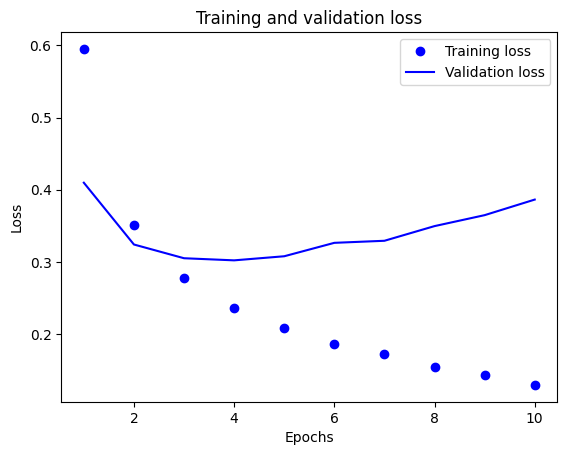

In [144]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


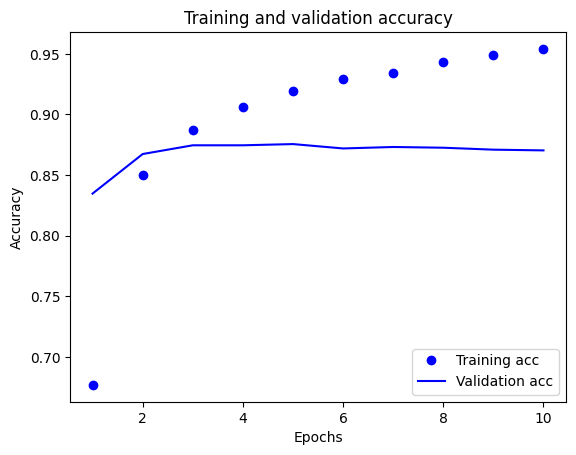

In [145]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

有 过拟合现象出现 训练集准确率逐渐上升，但在测试集上准确率达到顶点后开始下降，
通过设置EarlyStopping ，DropOut等方式来防止过拟合

## 导出模型

In [146]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss  = losses.BinaryCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics = ['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8506 - loss: 0.4584
0.8504800200462341


## 对新数据进行预测

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]
examples_tensor = tf.convert_to_tensor(examples)
# 必须要将新的数据类型转化为张量，模型才能进行处理
# Ensure the model can handle the data by passing the tensor through the export model
predictions = export_model.predict(examples_tensor)

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[0.7450576 ]
 [0.47260225]
 [0.26826346]]


 下次提交文本的多类分类

## 参考：[基本文本分类](https://www.tensorflow.org/tutorials/keras/text_classification?hl=zh-cn)